# Helper Functions

In [1]:
import sys
import os

cwd = os.getcwd()
root_path = os.path.abspath('..\..')
sys.path.insert(0, root_path)

print(sys.path)

['c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD', 'c:\\Users\\ronal\\OneDrive\\Documents\\GitHub\\BPAD\\analysis\\raw', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\python39.zip', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\DLLs', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\lib', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad', '', 'C:\\Users\\ronal\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\ronal\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32', 'C:\\Users\\ronal\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32\\lib', 'C:\\Users\\ronal\\AppData\\Roaming\\Python\\Python39\\site-packages\\Pythonwin', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\lib\\site-packages', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\lib\\site-packages\\win32', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpad\\lib\\site-packages\\win32\\lib', 'c:\\Users\\ronal\\miniconda3\\envs\\rcvdb-thesis-bpa

In [2]:
import numpy as np
import pandas as pd
import re

from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from utils.enums import Perspective

In [3]:
def plot_losses(results, labels, directory, experiment_name, run_name, perspective, level, bucket=None, zoom=[[11000,13000],[-0.05, 0.2]], show_plots=True):
    def scatter_plot(ax, results, labels):
        y_values = results
        x_values = np.arange(len(results))
        ax.scatter(x_values[labels == 0], y_values[labels == 0], c='grey', s=3, label='Normal Prefixes', zorder=1)
        ax.scatter(x_values[labels == 1], y_values[labels == 1], c='red', s=3, label='Anomalous Prefixes', zorder=2)
        ax.grid(True)

    # Normalize results
    results = np.interp(results, (results.min(), results.max()), (0, 1))

    subtitle = f'{experiment_name}     {run_name}'
    if len(results) == 0:
        print(f'ERROR no results found for {subtitle}')
    else:
        fig, ax = plt.subplots(figsize=(15, 6))

        labels = labels[:, perspective]
        scatter_plot(ax, results, labels)
        
        perspective_name = Perspective.values()[perspective]

        bucket_string = ''
        if bucket is not None:
            bucket_string = f'with bucket size {str(bucket)}'
        
        title = f'Error per Prefix on the {perspective_name} perspective at {level} level {bucket_string}'
        
        # Print to keep track of plotting
        # print(f'\t {title}')
        
        plt.title(f'{title}\n{subtitle}')
        plt.xlabel('Prefix Index')
        plt.ylabel('Loss')
        
        if zoom:
            axins = inset_axes(ax, width="60%", height="60%", loc='upper right')

            scatter_plot(axins, results, labels)
            axins.set_xlim(zoom[0])
            axins.set_ylim(zoom[1])
            _,_ = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=3)

        plt.xlabel('Case Index')
        plt.ylabel('Error')
        plt.legend(loc='upper right')
        
        plot_path = f"plots\{directory}\{run_name}\error_plots"
        os.makedirs(plot_path, exist_ok=True)
        plt.savefig(f"{plot_path}\{perspective_name}_{level}_{bucket_string}.png", format='png', dpi=300)
        
        if show_plots:
            plt.show()
        plt.close()

def bucket_plot_losses(results_name, labels_name, run_name, directory, experiment_name, bucket_lengths, results, perspective, level, zoom=[[11000,13000],[-0.05, 0.2]], show_plots=True, pbar=None):
    if bucket_lengths is None:
        plot_losses(
            results=results[f'{results_name}'], 
            labels=results[f'{labels_name}'],
            directory=directory,
            experiment_name=experiment_name,
            run_name=run_name, perspective=perspective, level=level, bucket=None, zoom=zoom, show_plots=show_plots)
        if pbar:
            pbar.update(1)       
    else:
        for bucket in bucket_lengths:
            plot_losses(
                results=results[f'{results_name}_{bucket}'], 
                labels=results[f'{labels_name}_{bucket}'],
                directory=directory,
                experiment_name=experiment_name,
                run_name=run_name, perspective=perspective, level=level, bucket=bucket, zoom=zoom, show_plots=show_plots)
            if pbar:
                pbar.update(1)  


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_single_score(data, score_type, level, ax, label_name, xlabel_name):
    subset = data[data["level"] == level]
    
    sns.lineplot(
        data=subset,
        x=label_name,
        y=score_type,
        hue="perspective",
        # style="categorical_encoding",
        markers=True,
        dashes=False,
        ax=ax
    )
    
    ax.set_title(f"{score_type.capitalize()} Scores (Level={level.capitalize()})")
    ax.set_xlabel(xlabel_name)
    ax.set_ylabel(f"{score_type.capitalize()}" if level=='trace' else "")
    ax.tick_params(axis="x", rotation=90)

def plot_scores(data, directory, experiment_name, title, label_name, xlabel_name, summary=True, filter_beginning_percentage=0, postfix=None, legend_title="Anomaly Perspective & Encoding", run_time=True):
    levels = ["trace", "event", "attribute"]
    
    if summary:
        if not run_time:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=False)
        else:
            fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=False)
    else:
        fig, axes = plt.subplots(6, 3, figsize=(18, 18), sharex=True, sharey=False)
    
    handles, labels = [], []

    for i, level in enumerate(levels):
        if not run_time:
            plot_single_score(data, "f1", level, axes[i], label_name, xlabel_name)
        else:
            plot_single_score(data, "f1", level, axes[0, i], label_name, xlabel_name)
            plot_single_score(data, "run_time", level, axes[1, i], label_name, xlabel_name)
        if not summary:
            plot_single_score(data, "pr_auc", level, axes[2, i], label_name, xlabel_name)
            plot_single_score(data, "roc_auc", level, axes[3, i], label_name, xlabel_name)
            plot_single_score(data, "precision", level, axes[4, i], label_name, xlabel_name)
            plot_single_score(data, "recall", level, axes[5, i], label_name, xlabel_name)

        if not handles and not labels:
            if not run_time:
                handles, labels = axes[i].get_legend_handles_labels()
            else:
                handles, labels = axes[0, i].get_legend_handles_labels()
        
        if not run_time:
            axes[i].legend().remove()
        else:
            axes[0, i].legend().remove()
            axes[1, i].legend().remove()
        if not summary:
            axes[2, i].legend().remove()
            axes[3, i].legend().remove()
            axes[4, i].legend().remove()
            axes[5, i].legend().remove()


    fig.legend(
        handles,
        labels,
        title=legend_title,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=3
    )
    
    fig.suptitle(f'F1-Scores: {experiment_name}: {title}', fontsize=16, fontweight='bold')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    if run_time:
        plt.subplots_adjust(top=0.92)

    plot_path = f"plots\{directory}"
    os.makedirs(plot_path, exist_ok=True)
    if postfix is not None:
        plt.savefig(f"{plot_path}\experimental_results_{title}_{postfix}_{filter_beginning_percentage}.png", format='png', dpi=300, bbox_inches="tight")
    else:
        plt.savefig(f"{plot_path}\experimental_results_{title}_{filter_beginning_percentage}.png", format='png', dpi=300, bbox_inches="tight")

    plt.show()

# Config

In [5]:
# 'Experiment_Real_World_Debug',
# 'Experiment_Prefix_v2',
# 'Experiment_Transformer_Debug_v2_93896'

directories = [
    # 'Experiment_Transformer_Event_Multi_Task'
    # 'Experiment_Transformer_Perspective_Weights_v2'
    # 'Experiment_Transformer_Event_Positional_Encoding'
    # 'Experiment_Transformer_Prefix_Store' 
    
    'Experiment_Prefix_v3',
    # 'Experiment_Batch_Size',
    # 'Experiment_Anomaly_Percentage_v2',
    # 'Experiment_Synthetic_Dataset_v4',

    # 'Experiment_Finetuning_Fixed_Vector_Vector_Sizes',
    # 'Experiment_Finetuning_T2V_Window_Vector_Sizes',
    # 'Experiment_Finetuning_W2V_Window_Vector_Sizes',

    # 'Experiment_Synthetic_All_Models',
    # 'Experiment_Real_World_All_Models',
    ]

# Get the root experiment name from directory
experiment_name = re.sub(r"_\d{5}$", "", directories[0])
model_type = 'Transformer' # '{model_type}'

filter_beginning_percentage = 0

recalculate = False

score_results = True
score_summary = True

rank_encoders = False
rank_cd_encoders = True

plot_results = False
show_plots = True


In [6]:
directory = directories[-1]
print(directory)

Experiment_Prefix_v3


In [7]:
from analysis.raw.utils.load_data import list_subfolders_or_zip_files


run_list = list_subfolders_or_zip_files(directory)
print(run_list)
print(run_list[0])

['24-11-29-19-28_DAE_One-Hot_25039.zip', '24-11-29-19-29_DAE_One-Hot_10089.zip', '24-11-29-19-29_DAE_One-Hot_12459.zip', '24-11-29-19-29_DAE_One-Hot_25494.zip', '24-11-29-19-29_DAE_One-Hot_39059.zip', '24-11-29-19-29_DAE_One-Hot_50503.zip', '24-11-29-19-29_DAE_One-Hot_56309.zip', '24-11-29-19-29_DAE_One-Hot_66632.zip', '24-11-29-19-29_DAE_One-Hot_74451.zip', '24-11-29-19-29_DAE_One-Hot_80758.zip', '24-11-29-19-29_DAE_One-Hot_90570.zip', '24-11-29-19-29_DAE_One-Hot_92738.zip', '24-11-29-19-30_DAE_One-Hot_36535.zip', '24-11-29-19-30_DAE_One-Hot_62441.zip', '24-11-29-19-30_DAE_One-Hot_90562.zip', '24-11-29-19-31_DAE_One-Hot_18911.zip', '24-11-29-19-31_DAE_One-Hot_24702.zip', '24-11-29-19-31_DAE_One-Hot_39392.zip', '24-11-29-19-31_DAE_One-Hot_40558.zip', '24-11-29-19-31_DAE_One-Hot_40926.zip', '24-11-29-19-31_DAE_One-Hot_42229.zip', '24-11-29-19-31_DAE_One-Hot_43499.zip', '24-11-29-19-31_DAE_One-Hot_45047.zip', '24-11-29-19-31_DAE_One-Hot_49263.zip', '24-11-29-19-31_DAE_One-Hot_52441.zip',

# Loading Runs

In [8]:
from analysis.raw.utils.load_data import load_score_dataframe

score_path = f"plots\{directory}\\"
score_file = f"scores_raw_df_{filter_beginning_percentage}.pkl"
all_scores_df = None

# Check if scores_raw_df.pkl exists and if yes skip reloading all data, force recalculation if set to true
if not recalculate:
    all_scores_df = load_score_dataframe(score_path + score_file)

DataFrame loaded successfully!


In [9]:
# If needed to merge two score dataframes
# directory_2 = 'Experiment_Real_World_All_Models_T2V_C'
# score_path_2 = f"plots\{directory_2}\\"

# if not recalculate:
#     all_scores_df_2 = load_score_dataframe(score_path_2 + score_file)
# result = pd.concat([all_scores_df, all_scores_df_2], axis=0, ignore_index=True)

# print(all_scores_df.shape)
# print(all_scores_df_2.shape)
# print(result.shape)

# os.makedirs(score_path, exist_ok=True)
# result.to_pickle(score_path + score_file)

In [10]:
from analysis.raw.utils.load_data import cleanup_temp_folders, get_buckets, load_config, load_results, unzip_results
from analysis.raw.utils.process_raw_data import score


runs = []
scores_dfs = []
total_runtime = 0

# If no scores_raw_df.pkl exists, recalulate is true or plotting individual runs start loading all data from raw
if all_scores_df is None or recalculate is True or plot_results is True:
    for index, run_name in enumerate(tqdm(run_list)):
        # try:
            # If needed unzip the data
            run_name, from_zip = unzip_results(directory, run_name)

            # Loading the data
            results = load_results(run_name=run_name, directory=directory)
            config = load_config(run_name=run_name, directory=directory)
            buckets = get_buckets(results.keys())
            timestamp = run_name.split('_')[0]

            # print("Buckets:", buckets)

            total_runtime += config['run_time']

            # If needed clean up temp folder
            if from_zip:
                cleanup_temp_folders(directory, run_name)
            
            # If set filter the first % of results from the run to allow the scoring some grace period
            if filter_beginning_percentage != 0:
                for key, value in results.items():
                    filter_index = int(value.shape[0] / filter_beginning_percentage)
                    # print(filter_index)
                    results[key] = value[filter_index:]


            run = {
                "name": run_name,
                "timestamp": timestamp,
                "results": results,
                "config": config,
                "buckets": buckets,
                "index": index,
            }

            # If no preloaded scores exist
            if (all_scores_df is None or recalculate is True) and (score_results is True or rank_encoders is True or rank_cd_encoders is True): 
                try:
                    scores_df = score(run=run)
                    scores_dfs.append(scores_df)
                except Exception as e:
                    print(f"Failed to score: {run_name}")
                    print(e)

            # Only save to runs if plotting results otherwise it is wasting memory
            if plot_results:
                runs.append(run)
        # except Exception as e:
        #     print(f"Failed to load: {run_name}")
        #     print(e)

print(len(scores_dfs))
# Save the scores dataframe to disk if it has calculated
if len(scores_dfs) != 0:
    all_scores_df = pd.concat(scores_dfs, ignore_index=True)
    os.makedirs(score_path, exist_ok=True)
    all_scores_df.to_pickle(score_path + score_file)

print(len(runs))

0
0


In [11]:
# if recalculate == True:
#     for i in range(0,4): 
#         labels = runs[0]['results']['labels_Transformer_trace'].T[i]
#         print(labels.shape)
#         true_count_y_true = np.sum(labels == 1)
#         false_count_y_true = np.sum(labels == 0)
#         # Anomalous, Normal
#         print(true_count_y_true, false_count_y_true)

In [12]:
# if recalculate == True:
#     debug_order_trace_labels = runs[0]['results']['labels_Transformer_trace'].T[Perspective.ORDER]
#     debug_order_event_labels = runs[0]['results']['labels_Transformer_event'].T[Perspective.ORDER].T
#     debug_order_attribute_labels = runs[0]['results']['labels_Transformer_attribute'].T[Perspective.ORDER].T

#     print(debug_order_attribute_labels.shape)
#     print(debug_order_event_labels.shape)
#     print(debug_order_trace_labels.shape)

#     debug_order_trace_results = runs[0]['results']['result_Transformer_trace_Order']
#     print(np.min(debug_order_trace_results), np.max(debug_order_trace_results))

In [13]:
if recalculate == True:
    scores_dfs[0]['model']

In [14]:
# processed_prefixes = np.array(config['processed_prefixes'])
# processed_events = np.array(config['processed_events'])
# print(processed_prefixes.shape)
# print(processed_events.shape)

In [15]:
if total_runtime != 0:
    output = f"Total runtime (multiple scales): \n{round(total_runtime / 3600, 2)} hours \n{round(total_runtime / 60, 2)} minutes \n{round(total_runtime, 2)} seconds"

    plot_path = f"plots\\{directory}"
    os.makedirs(plot_path, exist_ok=True)
    file_path = f"{plot_path}\\total_runtime.txt"

    with open(file_path, 'w') as file:
        file.write(output)

In [16]:
all_scores_df

,run_name,model,dataset,timestamp,index,level,perspective,roc_auc,pr_auc,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,numerical_encoding,vector_size,window_size
0,Experiment_Prefix_v3_34530,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,24-11-29-19-28,0,trace,Order,0,0,0.082192,0.022256,0.615720,21.670184,8,False,None,One Hot,Min Max Scaling,0,0
1,Experiment_Prefix_v3_34530,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,24-11-29-19-28,0,trace,Attribute,0,0,0.054545,0.018786,0.521648,21.670184,8,False,None,One Hot,Min Max Scaling,0,0
2,Experiment_Prefix_v3_34530,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,24-11-29-19-28,0,trace,Arrival Time,0,0,0.042898,0.018387,0.475411,21.670184,8,False,None,One Hot,Min Max Scaling,0,0
3,Experiment_Prefix_v3_34530,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,24-11-29-19-28,0,trace,Workload,0,0,0.436760,0.507225,0.314381,21.670184,8,False,None,One Hot,Min Max Scaling,0,0
4,Experiment_Prefix_v3_34530,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,24-11-29-19-28,0,trace,Single,0,0,0.426582,0.356879,0.590959,21.670184,8,False,None,One Hot,Min Max Scaling,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45967,Experiment_Prefix_v3_51026,DAE,process_log_24-11-21-12-07_p2p_0.45_4_9.json.gz,24-11-29-23-29,2553,attribute,Attribute,0,0,0.027253,0.012603,0.339295,89.827215,8,True,None,One Hot,Min Max Scaling,0,0
45968,Experiment_Prefix_v3_51026,DAE,process_log_24-11-21-12-07_p2p_0.45_4_9.json.gz,24-11-29-23-29,2553,attribute,Arrival Time,0,0,0.029858,0.014249,0.503522,89.827215,8,True,None,One Hot,Min Max Scaling,0,0
45969,Experiment_Prefix_v3_51026,DAE,process_log_24-11-21-12-07_p2p_0.45_4_9.json.gz,24-11-29-23-29,2553,attribute,Workload,0,0,0.024595,0.012783,0.101074,89.827215,8,True,None,One Hot,Min Max Scaling,0,0
45970,Experiment_Prefix_v3_51026,DAE,process_log_24-11-21-12-07_p2p_0.45_4_9.json.gz,24-11-29-23-29,2553,attribute,Single,0,0,0.026782,0.012704,0.302275,89.827215,8,True,None,One Hot,Min Max Scaling,0,0


In [17]:
print(all_scores_df.shape)
all_scores_df = all_scores_df.drop(columns=["run_name", "timestamp", "index", "numerical_encoding", "roc_auc", "pr_auc"])
all_scores_df["buckets"] = all_scores_df["buckets"].astype(str)
print(all_scores_df.shape)

(45972, 20)
(45972, 14)


In [18]:
all_scores_df.head(5)

,model,dataset,level,perspective,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,vector_size,window_size
0,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Order,0.082192,0.022256,0.615720,21.670184,8,False,None,One Hot,0,0
1,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Attribute,0.054545,0.018786,0.521648,21.670184,8,False,None,One Hot,0,0
2,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Arrival Time,0.042898,0.018387,0.475411,21.670184,8,False,None,One Hot,0,0
3,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Workload,0.436760,0.507225,0.314381,21.670184,8,False,None,One Hot,0,0
4,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Single,0.426582,0.356879,0.590959,21.670184,8,False,None,One Hot,0,0


# Plot Results

In [19]:
if plot_results:
    model_type = list(results.keys())[0].split('_')[1]
    print(model_type)
    results_config = [
        (f'result_{model_type}_trace_Order', f'labels_{model_type}_trace', Perspective.ORDER, 'trace'),
        (f'result_{model_type}_trace_Attribute', f'labels_{model_type}_trace', Perspective.ATTRIBUTE, 'trace'),
        (f'result_{model_type}_trace_Arrival Time', f'labels_{model_type}_trace', Perspective.ARRIVAL_TIME, 'trace'),
        (f'result_{model_type}_trace_Workload', f'labels_{model_type}_trace', Perspective.WORKLOAD, 'trace'),
    ]

    nr_buckets = 0
    for run in runs:
        if run["buckets"] is None:
            nr_buckets += 1
        else:
            nr_buckets += len(run["buckets"])

    total_iterations = nr_buckets * len(results_config)
    with tqdm(total=total_iterations, desc="Generating Plots") as pbar:
        for run in runs:
            # print(f"Generating: {directory}\t{run_name}")
            for config in results_config:
                
                # try:
                bucket_plot_losses(
                    results_name=config[0], 
                    labels_name=config[1],
                    directory=directory,
                    experiment_name=experiment_name,
                    run_name=run["name"],
                    bucket_lengths=run["buckets"],
                    results=run["results"],
                    perspective=config[2],
                    level=config[3],
                    zoom=None,
                    show_plots=show_plots,
                    pbar=pbar)
                # except:
                #     print("Error loading ")


# Score Results

In [20]:
# Generate additional rows for the encoding methods combined
group_cols = [
    "model", "dataset", "level", "perspective", "batch_size", "vector_size", "window_size", "prefix", "buckets"
]

averages_methods = (
    all_scores_df.groupby(group_cols)
    .agg({
        # "roc_auc": "mean", 
        # "pr_auc": "mean", 
        "f1": "mean", #["mean", "std"],
        "precision": "mean", 
        "recall": "mean",
        "run_time": "mean", #["mean", "std"]
    })
)

# averages_methods.columns = ['_'.join(col).strip('_') for col in averages_methods.columns]
averages_methods = averages_methods.reset_index()

averages_methods["categorical_encoding"] = "All"
# averages_methods["timestamp"] = "Average"

result_methods_df = pd.concat([all_scores_df, averages_methods], ignore_index=True)

In [21]:
averages_methods.head(8)

,model,dataset,level,perspective,batch_size,vector_size,window_size,prefix,buckets,f1,precision,recall,run_time,categorical_encoding
0,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,Arrival Time,8,0,0,False,None,0.006648,0.002499,0.580291,33.195490,All
1,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,Arrival Time,8,0,0,False,"[3, 4, 5, 6, 7, 8, 9, 15]",0.009616,0.002352,0.353456,21.764571,All
2,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,Arrival Time,8,0,0,True,None,0.004486,0.001704,0.571507,154.173507,All
3,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,Arrival Time,8,0,0,True,"[3, 4, 5, 6, 7, 8, 9, 15]",0.006696,0.002595,0.428139,74.855939,All
4,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,Arrival Time,8,160,2,False,None,0.006254,0.002375,0.529189,9.816840,All
5,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,Arrival Time,8,160,2,True,"[3, 4, 5, 6, 7, 8, 9, 15]",0.007078,0.003009,0.524748,68.906771,All
6,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,Attribute,8,0,0,False,None,0.008195,0.000966,0.269029,33.195490,All
7,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,Attribute,8,0,0,False,"[3, 4, 5, 6, 7, 8, 9, 15]",0.009798,0.001720,0.441369,21.764571,All


In [22]:
print(all_scores_df.shape)
print(averages_methods.shape)
print(result_methods_df.shape)

(45972, 14)
(4896, 14)
(50868, 14)


In [23]:
no_single_result_df = result_methods_df[~result_methods_df["perspective"].isin(("Single", "Single_OA"))]

In [24]:
no_single_result_df.head(5)

,model,dataset,level,perspective,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,vector_size,window_size
0,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Order,0.082192,0.022256,0.615720,21.670184,8,False,None,One Hot,0,0
1,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Attribute,0.054545,0.018786,0.521648,21.670184,8,False,None,One Hot,0,0
2,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Arrival Time,0.042898,0.018387,0.475411,21.670184,8,False,None,One Hot,0,0
3,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Workload,0.436760,0.507225,0.314381,21.670184,8,False,None,One Hot,0,0
6,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,event,Order,0.007531,0.002248,0.522725,21.670184,8,False,None,One Hot,0,0


In [25]:
# Generate additional rows for the perspectives combined
group_cols = [
    "model", "dataset", "level", "categorical_encoding", "batch_size", "vector_size", "window_size", "prefix", "buckets"
]
averages_perspective = (
    no_single_result_df.groupby(group_cols)
    .agg({
        # "roc_auc": "mean", 
        # "pr_auc": "mean", 
        "f1": "mean", 
        "precision": "mean", 
        "recall": "mean",
        "run_time": "mean"
    })
)

# averages_perspective.columns = ['_'.join(col).strip('_') for col in averages_perspective.columns]
averages_perspective = averages_perspective.reset_index()

averages_perspective["perspective"] = "Average"


result_df = pd.concat([result_methods_df, averages_perspective], ignore_index=True)

In [26]:
averages_perspective.head(5)

,model,dataset,level,categorical_encoding,batch_size,vector_size,window_size,prefix,buckets,f1,precision,recall,run_time,perspective
0,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,All,8,0,0,False,None,0.011917,0.004884,0.381464,33.195490,Average
1,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,All,8,0,0,False,"[3, 4, 5, 6, 7, 8, 9, 15]",0.031634,0.006568,0.440659,21.764571,Average
2,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,All,8,0,0,True,None,0.010863,0.004542,0.334061,154.173507,Average
3,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,All,8,0,0,True,"[3, 4, 5, 6, 7, 8, 9, 15]",0.023884,0.007239,0.458205,74.855939,Average
4,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,attribute,All,8,160,2,False,None,0.014938,0.004939,0.553909,9.816840,Average


In [27]:
print(result_methods_df.shape)
print(averages_perspective.shape)
print(result_df.shape)

(50868, 14)
(1632, 14)
(52500, 14)


In [28]:
result_df.head(5)

,model,dataset,level,perspective,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,vector_size,window_size
0,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Order,0.082192,0.022256,0.615720,21.670184,8,False,None,One Hot,0,0
1,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Attribute,0.054545,0.018786,0.521648,21.670184,8,False,None,One Hot,0,0
2,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Arrival Time,0.042898,0.018387,0.475411,21.670184,8,False,None,One Hot,0,0
3,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Workload,0.436760,0.507225,0.314381,21.670184,8,False,None,One Hot,0,0
4,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Single,0.426582,0.356879,0.590959,21.670184,8,False,None,One Hot,0,0


In [29]:
# Generate additional columns used in analysis
result_df["dataset_size"] = result_df["dataset"].str.split('_').str[3]
result_df["anomaly_percentage"] = result_df["dataset"].str.split('_').str[4]
result_df["anomaly_percentage"] = result_df["anomaly_percentage"].astype(float)
result_df["batch_size"] = result_df["batch_size"].astype(str)
result_df["vector_size"] = result_df["vector_size"].astype(str)
result_df["vector_window_size"] = result_df["vector_size"].astype(str) + '/' + result_df["window_size"].astype(str)
# result_df["prefix"] = result_df["prefix"].astype(str)
result_df["prefix"] = np.where(
    result_df["prefix"].astype(bool), 
    "Prefix", 
    "No Prefix"
)
result_df["buckets"] = np.where(
    result_df["buckets"].astype(str) == "None", 
    "No Bucketing", 
    "Bucketing"
)
result_df["prefix_buckets"] = result_df["prefix"].astype(str) + '/' + result_df["buckets"].astype(str)

In [30]:
result_df.shape

(52500, 18)

In [31]:
result_df.head(5)

,model,dataset,level,perspective,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,vector_size,window_size,dataset_size,anomaly_percentage,vector_window_size,prefix_buckets
0,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Order,0.082192,0.022256,0.615720,21.670184,8,No Prefix,No Bucketing,One Hot,0,0,gigantic,0.05,0/0,No Prefix/No Bucketing
1,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Attribute,0.054545,0.018786,0.521648,21.670184,8,No Prefix,No Bucketing,One Hot,0,0,gigantic,0.05,0/0,No Prefix/No Bucketing
2,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Arrival Time,0.042898,0.018387,0.475411,21.670184,8,No Prefix,No Bucketing,One Hot,0,0,gigantic,0.05,0/0,No Prefix/No Bucketing
3,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Workload,0.436760,0.507225,0.314381,21.670184,8,No Prefix,No Bucketing,One Hot,0,0,gigantic,0.05,0/0,No Prefix/No Bucketing
4,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Single,0.426582,0.356879,0.590959,21.670184,8,No Prefix,No Bucketing,One Hot,0,0,gigantic,0.05,0/0,No Prefix/No Bucketing


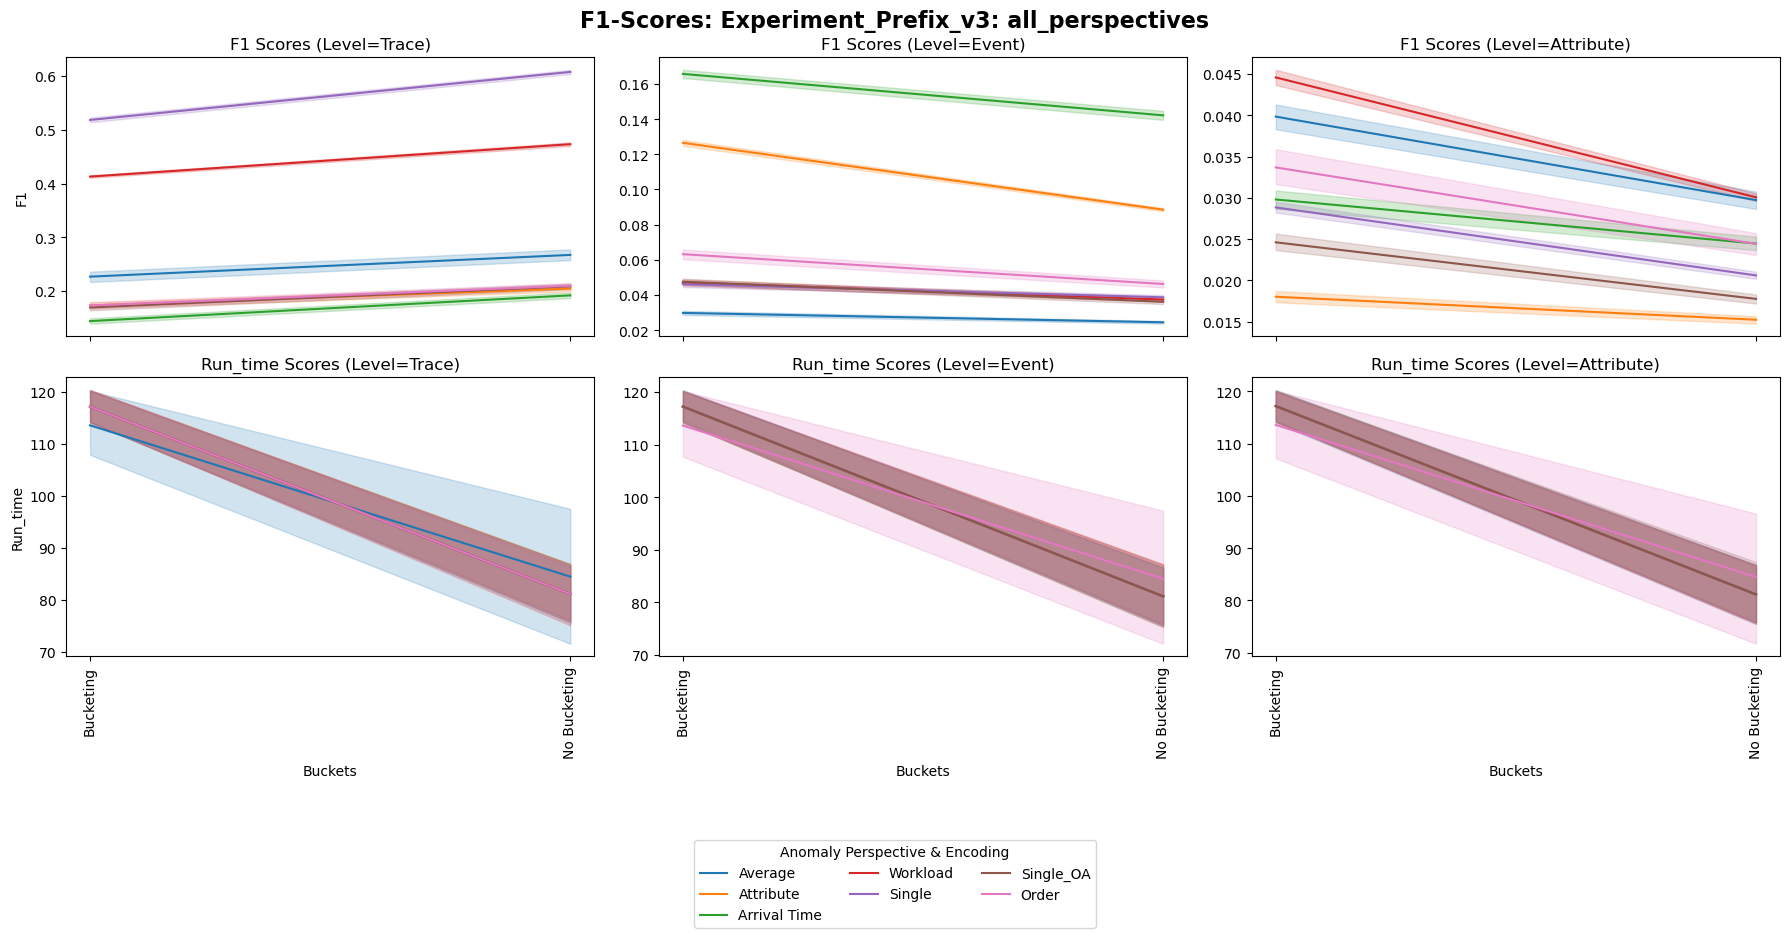

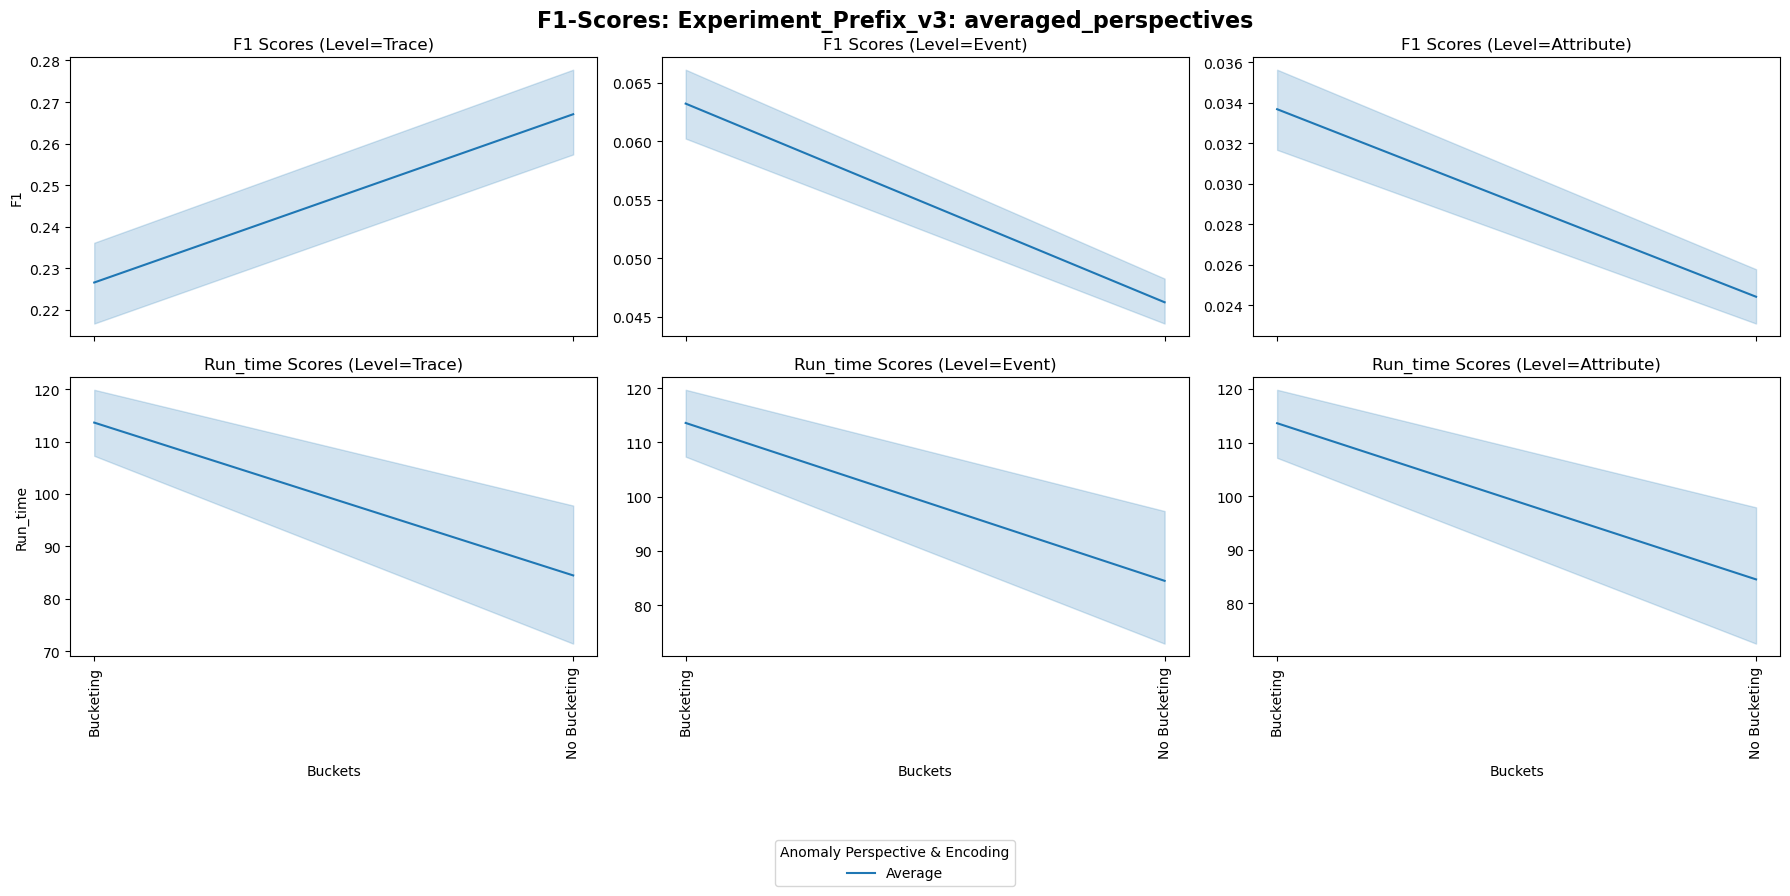

In [32]:
if score_results:
    if experiment_name == "Experiment_Anomaly_Percentage":
        xlabel_name="Anomaly Percentages"
        label_name="anomaly_percentage"
        plot_scores(result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(result_df[result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)

    elif experiment_name == "Experiment_Synthetic_Dataset":
        xlabel_name="Dataset Sizes"
        label_name="dataset_size"
        plot_scores(result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(result_df[result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)

    elif experiment_name == "Experiment_Batch_Size":
        xlabel_name="Batch Sizes"
        label_name="batch_size"
        plot_scores(result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(result_df[result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)

    elif experiment_name == "Experiment_Prefix_v3":
        xlabel_name="Buckets" # "Prefix/Buckets"
        label_name="buckets" #"prefix_buckets"

        sorted_result_df = result_df.sort_values(by=label_name, ascending=True)

        plot_scores(sorted_result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(sorted_result_df[sorted_result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
    
    elif experiment_name == "Experiment_Finetuning_Fixed_Vector_Vector_Sizes":
        filtered_result_df = result_df[result_df["categorical_encoding"] == "Fixed Vector"]

        xlabel_name="Vector Sizes"
        label_name="vector_size"

        plot_scores(filtered_result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(filtered_result_df[filtered_result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)  

    elif experiment_name == "Experiment_Finetuning_T2V_Window_Vector_Sizes":
        atc_filtered_result_df = result_df[result_df["categorical_encoding"] == "Trace2Vec Average Then Concatinate"]
        c_filtered_result_df = result_df[result_df["categorical_encoding"] == "Trace2Vec Concatinate"]

        xlabel_name="Vector/Window Sizes ATC"
        label_name="vector_window_size"
        plot_scores(atc_filtered_result_df, directory, experiment_name, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='ATC')
        plot_scores(atc_filtered_result_df[atc_filtered_result_df["perspective"] == "Average"], directory, experiment_name, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='ATC')
        xlabel_name="Vector/Window Sizes C"
        plot_scores(c_filtered_result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='C')
        plot_scores(c_filtered_result_df[c_filtered_result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='C')      
        
    elif experiment_name == "Experiment_Finetuning_W2V_Window_Vector_Sizes":
        atc_filtered_result_df = result_df[result_df["categorical_encoding"] == "Word2Vec Average Then Concatinate"]
        c_filtered_result_df = result_df[result_df["categorical_encoding"] == "Word2Vec Concatinate"]

        xlabel_name="Vector/Window Sizes ATC"
        label_name="vector_window_size"
        plot_scores(atc_filtered_result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='ATC')
        plot_scores(atc_filtered_result_df[atc_filtered_result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='ATC')
        xlabel_name="Vector/Window Sizes C"
        plot_scores(c_filtered_result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='C')
        plot_scores(c_filtered_result_df[c_filtered_result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name,summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, postfix='C')  

    elif experiment_name == "Experiment_Real_World_All_Models":
        filtered_result_df = result_df[result_df["categorical_encoding"] != "All"]

        print(filtered_result_df["categorical_encoding"].unique())

        xlabel_name="Categorical Encoding"
        label_name="categorical_encoding"
        plot_scores(filtered_result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(filtered_result_df[filtered_result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)  

    elif experiment_name == "Experiment_Synthetic_All_Models":
        filtered_result_df = result_df[result_df["categorical_encoding"] != "All"]

        print(filtered_result_df["categorical_encoding"].unique())

        xlabel_name="Categorical Encoding"
        label_name="categorical_encoding"
        plot_scores(filtered_result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage)
        plot_scores(filtered_result_df[filtered_result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage) 

    elif experiment_name == "Experiment_Transformer_Prefix_Store":
        filtered_result_df = result_df[result_df["categorical_encoding"] != "All"]

        print(filtered_result_df["model"].unique())
        print(filtered_result_df["perspective"].unique())

        filtered_result_df.sort_values(by=["model","level","perspective"])

        xlabel_name="Model"
        label_name="model"
        legend_title="Anomaly Perspectives"
        plot_scores(filtered_result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title)
        plot_scores(filtered_result_df[filtered_result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title) 

    elif experiment_name == "Experiment_Transformer_Event_Positional_Encoding":
        filtered_result_df = result_df[result_df["categorical_encoding"] != "All"]

        print(filtered_result_df["model"].unique())
        print(filtered_result_df["perspective"].unique())

        filtered_result_df.sort_values(by=["model","level","perspective"])

        xlabel_name="Model"
        label_name="model"
        legend_title="Anomaly Perspectives"
        plot_scores(filtered_result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title)
        plot_scores(filtered_result_df[filtered_result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title)

    elif experiment_name == "Experiment_Transformer_Perspective_Weights_v2":
        filtered_result_df = result_df[result_df["categorical_encoding"] != "All"]

        print(filtered_result_df["model"].unique())
        print(filtered_result_df["perspective"].unique())

        filtered_result_df.sort_values(by=["model","level","perspective"])

        # All models trained on a single perspective only
        only_models_df = filtered_result_df[filtered_result_df["model"].str.contains("only", case=False, na=False)]
        # All models trained on multiple perspectives
        other_models_df = filtered_result_df[~filtered_result_df["model"].str.contains("only", case=False, na=False)]

        xlabel_name="Model"
        label_name="model"
        legend_title="Anomaly Perspectives"
        postfix='single_perspective'
        plot_scores(only_models_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title, postfix=postfix)
        plot_scores(only_models_df[only_models_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title, postfix=postfix)
        postfix='weighted_perspective'
        plot_scores(other_models_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title, postfix=postfix)
        plot_scores(other_models_df[other_models_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title, postfix=postfix)    
        postfix=None
        plot_scores(filtered_result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title, postfix=postfix)
        plot_scores(filtered_result_df[filtered_result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title, postfix=postfix)    
    

    elif experiment_name == "Experiment_Transformer_Event_Multi_Task":
        filtered_result_df = result_df[result_df["categorical_encoding"] != "All"]

        print(filtered_result_df["model"].unique())
        print(filtered_result_df["perspective"].unique())

        filtered_result_df.sort_values(by=["model","level","perspective"])

        xlabel_name="Model"
        label_name="model"
        legend_title="Anomaly Perspectives"
        plot_scores(filtered_result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title)
        plot_scores(filtered_result_df[filtered_result_df["perspective"] == "Average"], directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title)  

    elif experiment_name == "Experiment_Offline_Training":
        filtered_result_df = result_df[result_df["categorical_encoding"] != "All"]

        print(filtered_result_df["model"].unique())
        print(filtered_result_df["perspective"].unique())

        filtered_result_df.sort_values(by=["model","level","perspective"])
        average_filtered_result_df = filtered_result_df[filtered_result_df["perspective"].isin(["Average", "Single", "Single_OA"])]

        run_time = False
        xlabel_name="Model"
        label_name="model"
        legend_title="Anomaly Perspectives"
        plot_scores(filtered_result_df, directory, experiment_name, "all_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title, run_time=run_time)
        plot_scores(average_filtered_result_df, directory, experiment_name, "averaged_perspectives", label_name=label_name, xlabel_name=xlabel_name, summary=score_summary, filter_beginning_percentage=filter_beginning_percentage, legend_title=legend_title, run_time=run_time)
     

# Rank Encoders

In [33]:
all_scores_df["dataset_short_name"] = all_scores_df["dataset"].str.split('_').str[3] + "/" + all_scores_df["dataset"].str.split('_').str[4]
all_scores_df["prefix_boolean"] = np.where(
    all_scores_df["prefix"].astype(bool), 
    "Prefix", 
    "No Prefix"
)
all_scores_df["buckets_boolean"] = np.where(
    all_scores_df["buckets"].astype(str) == "None", 
    "No Bucketing", 
    "Bucketing"
)
all_scores_df["prefix_buckets"] = all_scores_df["prefix_boolean"].astype(str) + '/' + all_scores_df["buckets_boolean"].astype(str)

In [34]:
all_scores_df.head(1)

,model,dataset,level,perspective,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,vector_size,window_size,dataset_short_name,prefix_boolean,buckets_boolean,prefix_buckets
0,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Order,0.082192,0.022256,0.61572,21.670184,8,False,None,One Hot,0,0,gigantic/0.05,No Prefix,No Bucketing,No Prefix/No Bucketing


In [35]:
def calculate_grouped_levels(df, group_by_index='dataset_short_name', rank_groupby_index='categorical_encoding'):
    grouped_all_levels = (
        df.groupby([group_by_index, rank_groupby_index, 'level'])[['f1']]
        .agg(['mean', 'std'])
        .reset_index()
    )
    # print(grouped_all_levels.shape)

    grouped_combined_levels = (
        df.groupby([group_by_index, rank_groupby_index])[['f1']]
        .agg(['mean', 'std'])
        .reset_index()
    )
    grouped_combined_levels['level'] = 'combined'
    # print(grouped_combined_levels.shape)
    
    grouped_levels = pd.concat([grouped_all_levels, grouped_combined_levels], axis=0, ignore_index=True)
    grouped_levels.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in grouped_levels.columns]
    # print(grouped_levels.shape)

    grouped_levels['f1_rank'] = grouped_levels.groupby([group_by_index, 'level'])['f1_mean'].rank(ascending=False)
    # print(grouped_levels.shape)

    return grouped_levels

In [36]:
if model_type == 'Transformer':
    grouped_levels = calculate_grouped_levels(all_scores_df, group_by_index='dataset_short_name', rank_groupby_index='model')
else:
    grouped_levels = calculate_grouped_levels(all_scores_df)

In [37]:
plot_path = f"plots\{directory}"
os.makedirs(plot_path, exist_ok=True)

grouped_levels.to_csv(f'{plot_path}\grouped_rank_stats.csv', index=False) 

In [38]:
grouped_levels

,dataset_short_name,model,level,f1_mean,f1_std,f1_rank
0,gigantic/0.05,DAE,attribute,0.015485,0.016984,1.0
1,gigantic/0.05,DAE,event,0.048949,0.061256,1.0
2,gigantic/0.05,DAE,trace,0.196551,0.210351,1.0
3,gigantic/0.1,DAE,attribute,0.013676,0.009260,1.0
4,gigantic/0.1,DAE,event,0.043331,0.044886,1.0
...,...,...,...,...,...,...
211,wide/0.25,DAE,combined,0.136865,0.137158,1.0
212,wide/0.3,DAE,combined,0.152082,0.139915,1.0
213,wide/0.35,DAE,combined,0.168160,0.158635,1.0
214,wide/0.4,DAE,combined,0.192932,0.177320,1.0


In [39]:
def calcualte_rank_stats(df, group_by_index=['categorical_encoding', 'level']):
    rank_stats_df = (
        df.groupby(group_by_index)
        .agg(
            rank_mean=('f1_rank', 'mean'),
            rank_std=('f1_rank', 'std'),
            f1_mean=('f1_mean', 'mean'),
            f1_std=('f1_mean', 'std')
        )
        .reset_index()
    )

    rank_stats_df['rank_std'] = rank_stats_df['rank_std'].fillna(0)
    rank_stats_df['f1_std'] = rank_stats_df['f1_std'].fillna(0)

    rank_stats_df['rank_mean'] = rank_stats_df['rank_mean'].round(2)
    rank_stats_df['rank_std'] = rank_stats_df['rank_std'].round(2)
    rank_stats_df['f1_mean'] = rank_stats_df['f1_mean'].round(2)
    rank_stats_df['f1_std'] = rank_stats_df['f1_std'].round(2)

    if len(group_by_index) == 2:
        rank_stats_df = rank_stats_df.sort_values(by=['level', 'rank_mean'], ascending=[True, True])
    else:
        rank_stats_df = rank_stats_df.sort_values(by=['rank_mean'], ascending=[True])
        
    return rank_stats_df

In [40]:
if model_type == 'Transformer':
    rank_stats_df = calcualte_rank_stats(grouped_levels, group_by_index=['model', 'level'])
else:
    rank_stats_df = calcualte_rank_stats(grouped_levels)

In [41]:
rank_stats_df

,model,level,rank_mean,rank_std,f1_mean,f1_std
0,DAE,attribute,1.0,0.0,0.03,0.01
1,DAE,combined,1.0,0.0,0.13,0.04
2,DAE,event,1.0,0.0,0.07,0.02
3,DAE,trace,1.0,0.0,0.30,0.08


In [42]:
plot_path = f"plots\{directory}"
os.makedirs(plot_path, exist_ok=True)

rank_stats_df.to_csv(f'{plot_path}\summarised_rank_stats.csv', index=False) 

## Naive Rank

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

if rank_encoders:
    sns.set_theme(style="white")
    g = sns.FacetGrid(grouped_levels, col="level", sharey=True, sharex=False, height=5, aspect=1.5, col_wrap=2)

    g.map_dataframe(
        sns.lineplot,
        x="dataset_short_name",
        y="f1_rank",
        hue="categorical_encoding",
        marker="o"
    )

    g.set_axis_labels("Dataset", "Rank (1 = Best)")
    g.set_titles("Level: {col_name}")
    plt.subplots_adjust(top=0.85)
    g.figure.suptitle(f"{experiment_name}: Ranking of Categorical Encodings methods per Dataset and Level", fontsize=16)

    # for ax in g.axes.flatten():
    #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    #     ax.grid(False)

    for ax in g.axes.flatten():
        # Get the current tick positions and labels
        tick_positions = ax.get_xticks()
        tick_labels = ax.get_xticklabels()

        # Set the ticks and labels explicitly with rotation
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')

        ax.grid(False)  # Turn off gridlines
        
    g.add_legend(title="Categorical Encoding", loc='upper left', bbox_to_anchor=(1.05, 1))

    plt.tight_layout()

    plot_path = f"plots\{directory}"
    os.makedirs(plot_path, exist_ok=True)
    plt.savefig(f"{plot_path}\encoding_ranking_per_dataset.png", format='png', dpi=300, bbox_inches="tight")

    plt.show()

In [44]:
import matplotlib.pyplot as plt
import os

def plot_rankings(data_df, title, rank_column='rank_mean', error_column='rank_std', sharey=True):
    levels = ['combined', 'trace', 'event', 'attribute']
    fig, axes = plt.subplots(1, len(levels), figsize=(15, 4), sharey=sharey)

    for i, level in enumerate(levels):
        ax = axes[i]
        level_data = data_df[data_df['level'] == level]
        
        level_data_sorted = level_data.sort_values(rank_column)
        ordered_categories = level_data_sorted['categorical_encoding']
        y_values = level_data_sorted[rank_column]
        errors = level_data_sorted[error_column]

        ax.bar(
            ordered_categories, 
            y_values, 
            yerr=errors,
            color='skyblue', 
            capsize=5,
            alpha=0.9
        )

        ax.set_title(f"Level: {level}")
        if i == 0:
            ax.set_ylabel("Average Rank (Lower = Better)")
        ax.tick_params(axis="x", rotation=90)
        ax.grid(False)
        ax.grid(axis='y', linestyle='--', color='gray', alpha=0.5)

    plt.subplots_adjust(top=0.85)
    fig.suptitle(f"{title}: Average {rank_column} with Uncertainty Margins per Level", fontsize=16)

    plot_path = f"plots/{directory}"
    os.makedirs(plot_path, exist_ok=True)
    plt.savefig(f"{plot_path}/encoding_rankings_summary_{rank_column}.png", format='png', dpi=300, bbox_inches="tight")

    plt.show()


In [45]:
if rank_encoders:
    plot_rankings(rank_stats_df, title='Rank', rank_column='rank_mean', error_column='rank_std', sharey=True)
    plot_rankings(rank_stats_df, title='F1', rank_column='f1_mean', error_column='f1_std', sharey=False)

# Critical Difference Rank

In [46]:
import Orange

# Dictionary mapping old values to new values
cd_rename_dict = {
    "One Hot": "One-Hot",
    "Word2Vec Concatinate": "Word2Vec C",
    "Word2Vec Average Then Concatinate": "Word2Vec ATC",
    "Trace2Vec Concatinate": "Trace2Vec C",
    "Trace2Vec Average Then Concatinate": "Trace2Vec ATC",
    "Fixed Vector": "Fixed-Vector"
}

def generate_cd_plot(rank_stats, level, nr_datasets, perspective, plot_path, group_by_index, sub_filter_encoding):
    rank_stats_lvl = rank_stats # rank_stats[rank_stats["level"] == level]
    names = rank_stats_lvl[group_by_index].to_list()
    avranks = rank_stats_lvl['rank_mean'].to_list()

    # Apply the rename using the dictionary
    names = [cd_rename_dict.get(name, name) for name in names]

    print(names)

    if sub_filter_encoding:
        filename = f"{plot_path}/CD_{sub_filter_encoding}_{perspective}_{level}.png"
    else:
        filename = f"{plot_path}/CD_{perspective}_{level}.png"

    # https://github.com/biolab/orange3/blob/e2282bbe2cf3d30ba41220ea2df0b79201ca430c/Orange/evaluation/scoring.py
    # Choosing Nemenyi as no method is seen as the baseline to which all others are compared
    cd = Orange.evaluation.scoring.compute_CD(avranks=avranks, n=nr_datasets, alpha="0.05", test='nemenyi')
    # print(cd)
    Orange.evaluation.scoring.graph_ranks(avranks=avranks, names=names, cd=cd, width=6, textspace=1.3, reverse=True, filename=filename) #textspace=3.2

In [47]:
from math import floor

def calculate_nr_repeats(df, group_by_index='dataset_short_name', rank_groupby_index='categorical_encoding'):
    unique_combinations = df[[group_by_index, rank_groupby_index, 'level','perspective']].drop_duplicates()
    return floor(df.shape[0]/len(unique_combinations))

In [48]:
all_scores_df

,model,dataset,level,perspective,f1,precision,recall,run_time,batch_size,prefix,buckets,categorical_encoding,vector_size,window_size,dataset_short_name,prefix_boolean,buckets_boolean,prefix_buckets
0,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Order,0.082192,0.022256,0.615720,21.670184,8,False,None,One Hot,0,0,gigantic/0.05,No Prefix,No Bucketing,No Prefix/No Bucketing
1,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Attribute,0.054545,0.018786,0.521648,21.670184,8,False,None,One Hot,0,0,gigantic/0.05,No Prefix,No Bucketing,No Prefix/No Bucketing
2,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Arrival Time,0.042898,0.018387,0.475411,21.670184,8,False,None,One Hot,0,0,gigantic/0.05,No Prefix,No Bucketing,No Prefix/No Bucketing
3,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Workload,0.436760,0.507225,0.314381,21.670184,8,False,None,One Hot,0,0,gigantic/0.05,No Prefix,No Bucketing,No Prefix/No Bucketing
4,DAE,process_log_24-11-21-12-07_gigantic_0.05_4_1.j...,trace,Single,0.426582,0.356879,0.590959,21.670184,8,False,None,One Hot,0,0,gigantic/0.05,No Prefix,No Bucketing,No Prefix/No Bucketing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45967,DAE,process_log_24-11-21-12-07_p2p_0.45_4_9.json.gz,attribute,Attribute,0.027253,0.012603,0.339295,89.827215,8,True,None,One Hot,0,0,p2p/0.45,Prefix,No Bucketing,Prefix/No Bucketing
45968,DAE,process_log_24-11-21-12-07_p2p_0.45_4_9.json.gz,attribute,Arrival Time,0.029858,0.014249,0.503522,89.827215,8,True,None,One Hot,0,0,p2p/0.45,Prefix,No Bucketing,Prefix/No Bucketing
45969,DAE,process_log_24-11-21-12-07_p2p_0.45_4_9.json.gz,attribute,Workload,0.024595,0.012783,0.101074,89.827215,8,True,None,One Hot,0,0,p2p/0.45,Prefix,No Bucketing,Prefix/No Bucketing
45970,DAE,process_log_24-11-21-12-07_p2p_0.45_4_9.json.gz,attribute,Single,0.026782,0.012704,0.302275,89.827215,8,True,None,One Hot,0,0,p2p/0.45,Prefix,No Bucketing,Prefix/No Bucketing


1242
['No Bucketing', 'Bucketing']
['No Bucketing', 'Bucketing']
['Bucketing', 'No Bucketing']
['Bucketing', 'No Bucketing']
['No Bucketing', 'Bucketing']
['No Bucketing', 'Bucketing']
['Bucketing', 'No Bucketing']
['Bucketing', 'No Bucketing']
['No Bucketing', 'Bucketing']
['No Bucketing', 'Bucketing']
['Bucketing', 'No Bucketing']
['Bucketing', 'No Bucketing']
['No Bucketing', 'Bucketing']
['No Bucketing', 'Bucketing']
['Bucketing', 'No Bucketing']
['Bucketing', 'No Bucketing']
['No Bucketing', 'Bucketing']
['No Bucketing', 'Bucketing']
['Bucketing', 'No Bucketing']
['Bucketing', 'No Bucketing']
['No Bucketing', 'Bucketing']


c:\Users\ronal\miniconda3\envs\rcvdb-thesis-bpad\lib\site-packages\Orange\evaluation\scoring.py:547: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(width, height))


['No Bucketing', 'Bucketing']
['Bucketing', 'No Bucketing']
['Bucketing', 'No Bucketing']
['No Bucketing', 'Bucketing']
['No Bucketing', 'Bucketing']
['Bucketing', 'No Bucketing']
['Bucketing', 'No Bucketing']


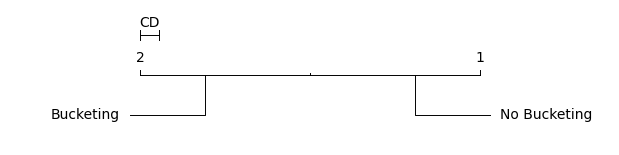

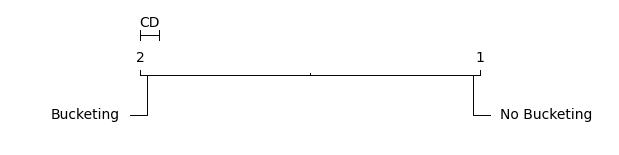

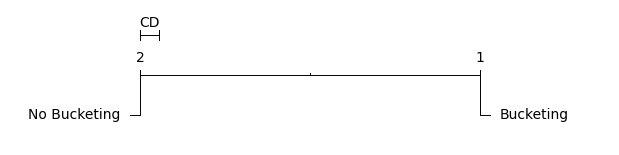

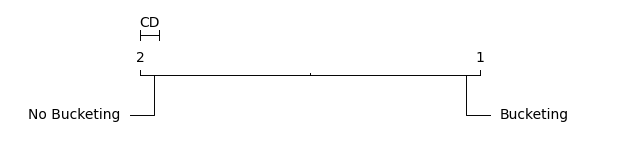

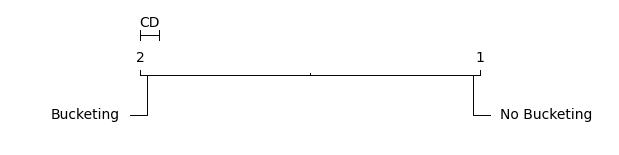

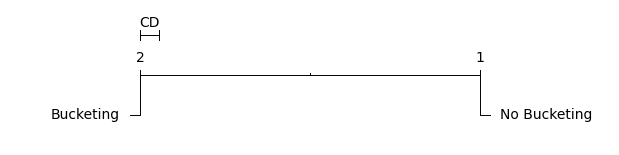

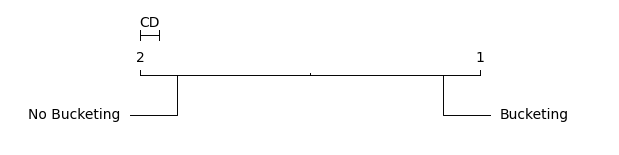

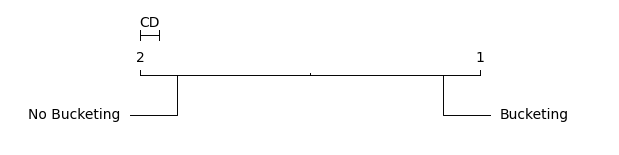

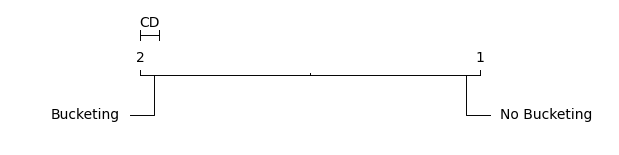

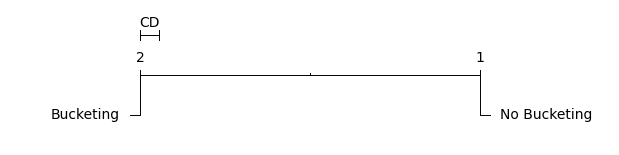

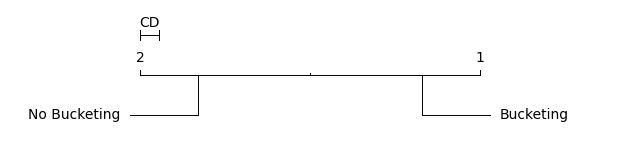

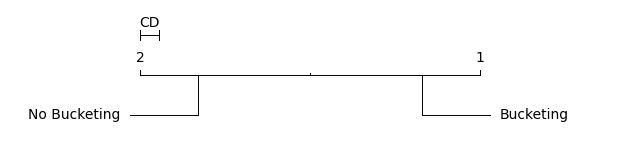

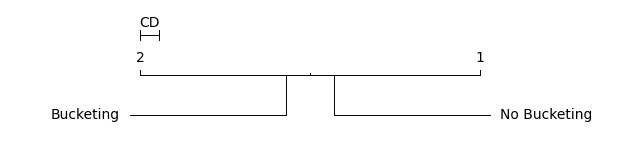

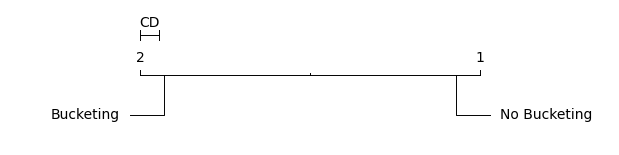

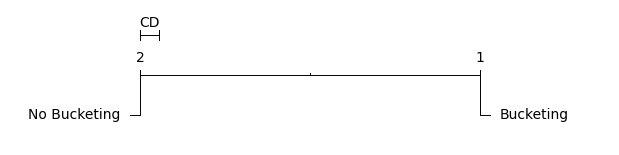

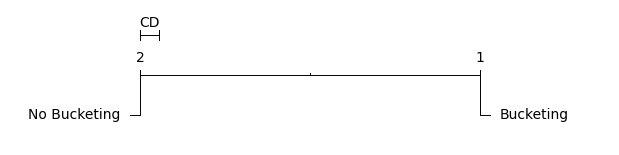

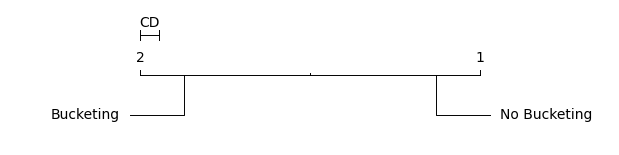

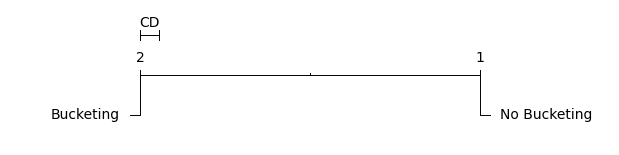

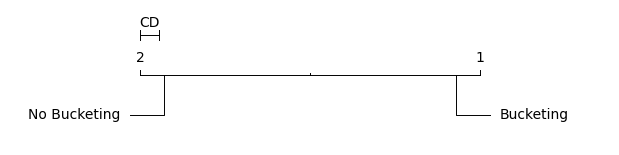

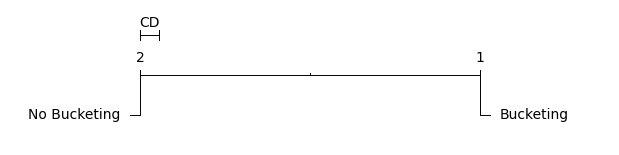

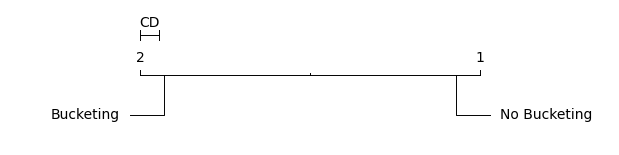

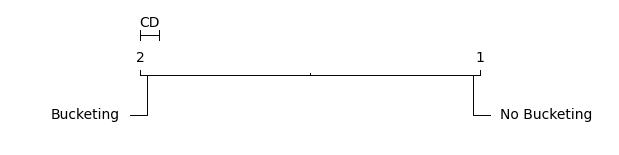

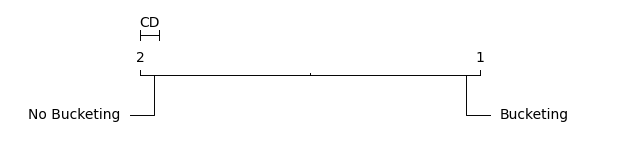

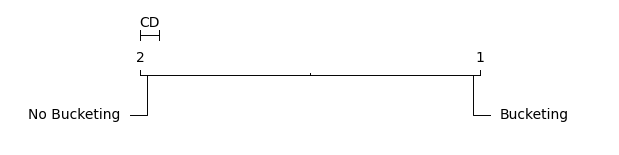

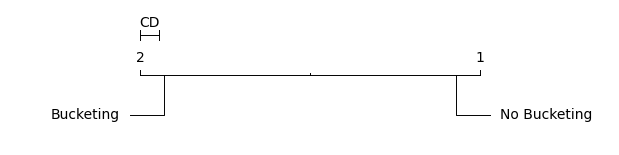

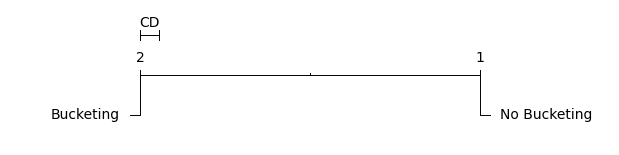

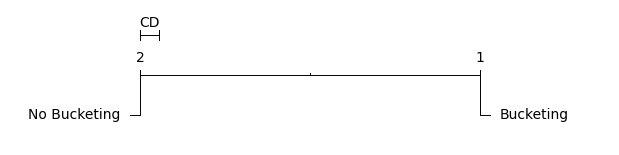

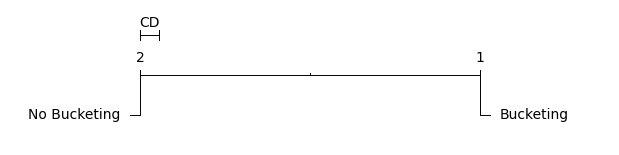

In [49]:
sub_filter_encodings = [None]
if experiment_name == "Experiment_Anomaly_Percentage":
    level_groupby_index =  'categorical_encoding'
    rank_groupby_index = 'dataset_short_name'
elif experiment_name == "Experiment_Finetuning_T2V_Window_Vector_Sizes" or experiment_name == "Experiment_Finetuning_W2V_Window_Vector_Sizes" or experiment_name == "Experiment_Finetuning_Fixed_Vector_Vector_Sizes":
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'categorical_encoding'
    sub_filter_encodings = all_scores_df["categorical_encoding"].unique()
    all_scores_df["categorical_encoding"] = all_scores_df["categorical_encoding"] + "[" + all_scores_df["vector_size"].astype(str) + "," + all_scores_df["window_size"].astype(str) + "]"
elif experiment_name == "Experiment_Finetuning_Fixed_Vector_Vector_Sizes":
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'categorical_encoding'
    sub_filter_encodings = all_scores_df["categorical_encoding"].unique()
    all_scores_df["categorical_encoding"] = all_scores_df["categorical_encoding"] + "[" + all_scores_df["vector_size"].astype(str) + "]"
elif experiment_name == "Experiment_Prefix_v3":
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'buckets_boolean' # 'prefix_buckets'
elif experiment_name == "Experiment_Transformer_Prefix_Store":
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'model' 
elif experiment_name == "Experiment_Transformer_Event_Positional_Encoding":
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'model'
elif experiment_name == "Experiment_Transformer_Perspective_Weights":
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'model'    
elif experiment_name == "Experiment_Transformer_Perspective_Multi_Task":
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'model'
elif experiment_name == "Experiment_Offline_Training":
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'model'
else: # Default to rank by encoder unless otherwise specified
    level_groupby_index = 'dataset_short_name'
    rank_groupby_index = 'categorical_encoding'

# print(sub_filter_encodings)
# print(all_scores_df["categorical_encoding"].unique())

all_rank_stats = []
if rank_cd_encoders:
    plot_path = f"plots/{directory}/CD_ranking"
    os.makedirs(plot_path, exist_ok=True)

    # Effective number of datasets because the critical difference depends on the total number of test results, not necessarily their source.
    nr_datasets = len(all_scores_df[level_groupby_index].unique()) * calculate_nr_repeats(all_scores_df)
    print(nr_datasets)
    perspectives = all_scores_df['perspective'].unique()
    perspectives = np.append(perspectives, 'Average')

    levels = ["combined", "trace", "event", "attribute"]
    for sub_filter_encoding in sub_filter_encodings:
        if sub_filter_encoding is not None:
            all_scores_df_filtered = all_scores_df[all_scores_df['categorical_encoding'].str.contains(sub_filter_encoding)]
           # print(scoring_df.shape)
        else:
            all_scores_df_filtered = all_scores_df

        for perspective in perspectives:
            for level in levels:
                # print(f'filtering {perspective}')
                # print(perspective)
                if perspective != 'Average':
                    scoring_df = all_scores_df_filtered[all_scores_df_filtered['perspective'] == perspective]
                else:
                    # print('Not filtering')
                    # print(f'shape before perspective filtering {all_scores_df_filtered.shape}')
                    scoring_df = all_scores_df_filtered
                    # print(f'shape after perspective filtering {scoring_df.shape}')
                
                # print(grouped_levels.shape)
                grouped_levels = calculate_grouped_levels(scoring_df,group_by_index=level_groupby_index, rank_groupby_index=rank_groupby_index)
                grouped_levels = grouped_levels[grouped_levels['level'] == level]
                # print(grouped_levels.columns)
            
                rank_stats_df = calcualte_rank_stats(grouped_levels, group_by_index=[rank_groupby_index])
                # print(rank_stats_df)

                generate_cd_plot(rank_stats_df, level=level, nr_datasets=nr_datasets, perspective=perspective, plot_path=plot_path, group_by_index=rank_groupby_index, sub_filter_encoding=sub_filter_encoding)

                rank_stats_concat = rank_stats_df.copy()
                rank_stats_concat['perspective'] = perspective
                rank_stats_concat['level'] = level
                all_rank_stats.append(rank_stats_concat)

# Table Results

In [50]:
scores_table = all_scores_df.drop(columns=["precision", "recall", "batch_size", "vector_size", "window_size", "prefix", "buckets", "prefix_boolean", "buckets_boolean", "prefix_buckets"])


In [51]:
scores_table = scores_table.drop(columns=["model", "dataset"])

In [52]:
scores_table = scores_table[["dataset_short_name", "level", "categorical_encoding", "perspective", "f1", "run_time"]]

In [53]:
scores_table.head(7)

,dataset_short_name,level,categorical_encoding,perspective,f1,run_time
0,gigantic/0.05,trace,One Hot,Order,0.082192,21.670184
1,gigantic/0.05,trace,One Hot,Attribute,0.054545,21.670184
2,gigantic/0.05,trace,One Hot,Arrival Time,0.042898,21.670184
3,gigantic/0.05,trace,One Hot,Workload,0.436760,21.670184
4,gigantic/0.05,trace,One Hot,Single,0.426582,21.670184
5,gigantic/0.05,trace,One Hot,Single_OA,0.067708,21.670184
6,gigantic/0.05,event,One Hot,Order,0.007531,21.670184


In [54]:
scores_table_no_single_result = scores_table[~scores_table["perspective"].isin(("Single", "Single_OA"))]
print(scores_table_no_single_result["perspective"].unique())

['Order' 'Attribute' 'Arrival Time' 'Workload']


In [55]:
# Generate additional rows for the perspectives combined
group_cols = [
    "dataset_short_name", "level", "categorical_encoding"
]
averages_perspective = (
    scores_table_no_single_result.groupby(group_cols)
    .agg({
        "f1": "mean",
        # "f1": "std",
        "run_time": "mean",
        # "run_time": "std"
    })
)

# averages_perspective.columns = ['_'.join(col).strip('_') for col in averages_perspective.columns]
averages_perspective = averages_perspective.reset_index()

averages_perspective["perspective"] = "Average"


scores_table = pd.concat([scores_table, averages_perspective], ignore_index=True)

In [56]:
# Generate additional rows for the perspectives combined
group_cols = [
    "dataset_short_name", "perspective", "categorical_encoding"
]
combined_levels = (
    scores_table.copy().groupby(group_cols)
    .agg({
        "f1": "mean",
        # "f1": "std",
        "run_time": "mean",
        # "run_time": "std"
    })
)

# averages_perspective.columns = ['_'.join(col).strip('_') for col in averages_perspective.columns]
combined_levels = combined_levels.reset_index()

combined_levels["level"] = "combined"


scores_table = pd.concat([scores_table, combined_levels], ignore_index=True)

In [57]:
averages_perspective.head(5)

,dataset_short_name,level,categorical_encoding,f1,run_time,perspective
0,gigantic/0.05,attribute,One Hot,0.017874,77.373837,Average
1,gigantic/0.05,attribute,Word2Vec Average Then Concatinate,0.016933,36.407309,Average
2,gigantic/0.05,event,One Hot,0.038909,77.373837,Average
3,gigantic/0.05,event,Word2Vec Average Then Concatinate,0.041281,36.407309,Average
4,gigantic/0.05,trace,One Hot,0.155409,77.373837,Average


In [58]:
combined_levels.head(5)

,dataset_short_name,perspective,categorical_encoding,f1,run_time,level
0,gigantic/0.05,Arrival Time,One Hot,0.017473,77.373837,combined
1,gigantic/0.05,Arrival Time,Word2Vec Average Then Concatinate,0.018175,36.407309,combined
2,gigantic/0.05,Attribute,One Hot,0.023984,77.373837,combined
3,gigantic/0.05,Attribute,Word2Vec Average Then Concatinate,0.014447,36.407309,combined
4,gigantic/0.05,Average,One Hot,0.070731,77.373837,combined


In [59]:
scores_table.head(5)

,dataset_short_name,level,categorical_encoding,perspective,f1,run_time
0,gigantic/0.05,trace,One Hot,Order,0.082192,21.670184
1,gigantic/0.05,trace,One Hot,Attribute,0.054545,21.670184
2,gigantic/0.05,trace,One Hot,Arrival Time,0.042898,21.670184
3,gigantic/0.05,trace,One Hot,Workload,0.436760,21.670184
4,gigantic/0.05,trace,One Hot,Single,0.426582,21.670184


In [60]:
scores_table["temp_count"] = 1
scores_table_mean = scores_table.groupby(
    ["level", "categorical_encoding", "perspective"]
    ).agg(f1_mean=("f1", "mean"), f1_std=("f1", "std"), run_time_mean=("run_time", "mean"), run_time_std=("run_time", "std"), temp_count=("temp_count", "sum")).reset_index()

In [61]:
scores_table_mean.head(10)

,level,categorical_encoding,perspective,f1_mean,f1_std,run_time_mean,run_time_std,temp_count
0,attribute,One Hot,Arrival Time,0.024608,0.018015,128.501814,113.663490,1514
1,attribute,One Hot,Attribute,0.014579,0.009658,128.501814,113.663490,1514
2,attribute,One Hot,Average,0.025738,0.012430,121.678329,57.147497,54
3,attribute,One Hot,Order,0.027566,0.020865,128.501814,113.663490,1514
4,attribute,One Hot,Single,0.021647,0.011743,128.501814,113.663490,1514
5,attribute,One Hot,Single_OA,0.019220,0.014485,128.501814,113.663490,1514
6,attribute,One Hot,Workload,0.032050,0.012079,128.501814,113.663490,1514
7,attribute,Word2Vec Average Then Concatinate,Arrival Time,0.029239,0.017499,45.348908,44.199487,1040
8,attribute,Word2Vec Average Then Concatinate,Attribute,0.018788,0.011259,45.348908,44.199487,1040
9,attribute,Word2Vec Average Then Concatinate,Average,0.032823,0.014203,44.997890,10.610310,54


In [62]:
all_rank_stats_df = pd.concat(all_rank_stats, ignore_index=True)

In [63]:
all_rank_stats_df.drop(columns=['f1_mean', 'f1_std', 'rank_std'], inplace=True)

In [64]:
all_rank_stats_df = all_rank_stats_df[["level", "categorical_encoding", "perspective", "rank_mean"]]
all_rank_stats_df = all_rank_stats_df.rename(columns={"rank_mean": "rank"})

KeyError: "['categorical_encoding'] not in index"

In [ ]:
print(scores_table['perspective'].unique())
print(all_rank_stats_df['perspective'].unique())
print(scores_table['level'].unique())
print(all_rank_stats_df['level'].unique())
print(scores_table_mean.shape)
print(all_rank_stats_df.shape)

['Order' 'Attribute' 'Arrival Time' 'Workload' 'Single' 'Single_OA'
 'Average']
['Order' 'Attribute' 'Arrival Time' 'Workload' 'Single' 'Single_OA'
 'Average']
['trace' 'event' 'attribute' 'combined']
['combined' 'trace' 'event' 'attribute']
(168, 8)
(168, 4)


In [ ]:
all_rank_stats_df.head(1)

,level,categorical_encoding,perspective,rank
0,combined,Trace2Vec Concatinate,Order,1.83


In [ ]:
scores_table_mean.head(1)

,level,categorical_encoding,perspective,f1_mean,f1_std,run_time_mean,run_time_std,temp_count
0,attribute,Fixed Vector,Arrival Time,0.032965,0.024219,76.12678,23.632677,90


In [ ]:
# Flatten the multi-columns
# scores_table_mean.columns = ['_'.join(col).strip('_') for col in scores_table_mean.columns]

In [ ]:
scores_table_mean_rank = pd.merge(scores_table_mean, all_rank_stats_df, on=["level", "categorical_encoding", "perspective"], how="outer")

In [ ]:
scores_table_mean_rank

,level,categorical_encoding,perspective,f1_mean,f1_std,run_time_mean,run_time_std,temp_count,rank
0,attribute,Fixed Vector,Arrival Time,0.032965,0.024219,76.126780,23.632677,90,2.72
1,attribute,Fixed Vector,Attribute,0.017745,0.012546,76.126780,23.632677,90,5.06
2,attribute,Fixed Vector,Average,0.031022,0.016771,76.126780,18.562594,18,4.67
3,attribute,Fixed Vector,Order,0.044571,0.029250,76.126780,23.632677,90,3.50
4,attribute,Fixed Vector,Single,0.026164,0.009789,76.126780,23.632677,90,4.44
...,...,...,...,...,...,...,...,...,...
163,trace,Word2Vec Concatinate,Average,0.225541,0.095911,59.435228,12.203789,18,3.33
164,trace,Word2Vec Concatinate,Order,0.177187,0.124479,60.147014,14.863610,102,4.28
165,trace,Word2Vec Concatinate,Single,0.505203,0.101947,60.147014,14.863610,102,4.00
166,trace,Word2Vec Concatinate,Single_OA,0.194863,0.131779,60.147014,14.863610,102,1.89


In [ ]:
score_table_pivot = scores_table_mean_rank.copy()

In [ ]:
# Compute the pooled standard deviation
def pooled_std(group):
    n = group["temp_count"]
    stds = group["run_time_std"]
    return np.sqrt(((n - 1) * (stds ** 2)).sum() / (n.sum() - 1))

# Apply pooled standard deviation calculation
runtime_stds_pooled = score_table_pivot.groupby(["level", "categorical_encoding"]).apply(pooled_std).reset_index(name="run_time_std")


In [ ]:
runtime_stds_pooled.head(1)

,level,categorical_encoding,run_time_std
0,attribute,Fixed Vector,23.365741


In [ ]:
# Aggregate run_time_mean and run_time_std across all perspectives
runtime_mean_pooled = score_table_pivot.groupby(["level", "categorical_encoding"])[["run_time_mean"]].mean().reset_index()

In [ ]:
score_table_perspective_pivot = score_table_pivot.pivot(index=["level", "categorical_encoding"], columns="perspective", values=["f1_mean", "f1_std", "rank"])

In [ ]:
score_table_perspective_pivot.head(2)

f1_mean                                \
perspective                    Arrival Time Attribute   Average     Order   
level     categorical_encoding                                              
attribute Fixed Vector             0.032965  0.017745  0.031022  0.044571   
          One Hot                  0.029897  0.019482  0.032772  0.037363   

                                                                   f1_std  \
perspective                       Single Single_OA  Workload Arrival Time   
level     categorical_encoding                                              
attribute Fixed Vector          0.026164  0.024102  0.028807     0.024219   
          One Hot               0.030053  0.026922  0.044346     0.022907   

                                                    ...                      \
perspective                    Attribute   Average  ...    Single Single_OA   
level     categorical_encoding                      ...                       
attribute Fixed Vector          0.012546  0.016771  ...  0.009789  0.015701   
          One Hot               0.014282  0.016785  ...  0.013469  0.019433   

                                                 rank                          \
perspective                     Workload Arrival Time Attribute Average Order   
level     categorical_encoding                                                  
attribute Fixed Vector          0.004546         2.72      5.06    4.67  3.50   
          One Hot               0.014324         5.56      3.22    3.56  5.44   

                                                          
perspective                    Single Single_OA Workload  
level     categorical_encoding                            
attribute Fixed Vector           4.44      4.00     5.11  
          One Hot                2.50      2.11     2.33  

[2 rows x 21 columns]

In [ ]:
score_table_perspective_pivot.columns = [f"{metric}_{persp}" for metric, persp in score_table_perspective_pivot.columns]

In [ ]:
score_table_perspective_pivot.reset_index(inplace=True)

In [ ]:
score_table_perspective_pivot_final = pd.merge(score_table_perspective_pivot, runtime_mean_pooled, on=["level", "categorical_encoding"], how="left")
score_table_perspective_pivot_final = pd.merge(score_table_perspective_pivot_final, runtime_stds_pooled, on=["level", "categorical_encoding"], how="left")

In [ ]:
# Define the correct column order
ordered_columns = [
    "level", "categorical_encoding",
    # Average Perspective
    "rank_Average", "f1_mean_Average", "f1_std_Average",
    # Single Perspective
    "rank_Single", "f1_mean_Single", "f1_std_Single",
    # Single_OA Perspective
    "rank_Single_OA", "f1_mean_Single_OA", "f1_std_Single_OA",
    # Order Perspective
    "rank_Order", "f1_mean_Order", "f1_std_Order",
    # Attribute Perspective
    "rank_Attribute", "f1_mean_Attribute", "f1_std_Attribute",
    # Arrival Time Perspective
    "rank_Arrival Time", "f1_mean_Arrival Time", "f1_std_Arrival Time",
    # Workload Perspective
    "rank_Workload", "f1_mean_Workload", "f1_std_Workload",
    # Runtime Statistics
    "run_time_mean", "run_time_std"
]

# Reorder the DataFrame
score_table_perspective_pivot_final = score_table_perspective_pivot_final[ordered_columns]

In [ ]:
# Custom order for 'level'
level_order = ["trace", "event", "attribute", "combined"]

# Custom order for 'categorical_encoding'
categorical_encoding_order = [
    "One Hot", "Word2Vec Concatinate", "Word2Vec Average Then Concatinate", 
    "Trace2Vec Concatinate", "Trace2Vec Average Then Concatinate", "Fixed Vector"
]

# Apply the custom order to the 'level' column
score_table_perspective_pivot_final['level'] = pd.Categorical(score_table_perspective_pivot_final['level'], categories=level_order, ordered=True)

# Apply the custom order to the 'categorical_encoding' column
score_table_perspective_pivot_final['categorical_encoding'] = pd.Categorical(score_table_perspective_pivot_final['categorical_encoding'], categories=categorical_encoding_order, ordered=True)

# Now sort the DataFrame based on the custom order
score_table_perspective_pivot_final = score_table_perspective_pivot_final.sort_values(by=["level", "categorical_encoding"])

In [ ]:
# Dictionary mapping old values to new values
rename_dict = {
    "One Hot": "One-Hot",
    "Word2Vec Concatinate": "Word2Vec C",
    "Word2Vec Average Then Concatinate": "Word2Vec ATC",
    "Trace2Vec Concatinate": "Trace2Vec C",
    "Trace2Vec Average Then Concatinate": "Trace2Vec ATC",
    "Fixed Vector": "Fixed-Vector"
}

# Apply the rename using the dictionary
score_table_perspective_pivot_final['categorical_encoding'] = score_table_perspective_pivot_final['categorical_encoding'].replace(rename_dict)

In [ ]:
score_table_perspective_pivot_final = score_table_perspective_pivot_final.round(3)

In [ ]:
score_table_perspective_pivot_final_no_single = score_table_perspective_pivot_final.drop(columns=["rank_Single", "f1_mean_Single", "f1_std_Single", "rank_Single_OA", "f1_mean_Single_OA", "f1_std_Single_OA"])
score_table_perspective_pivot_final_no_single_no_rank = score_table_perspective_pivot_final_no_single.drop(columns=["rank_Average", "rank_Order", "rank_Attribute", "rank_Arrival Time", "rank_Workload"])
score_table_perspective_pivot_final_no_single_only_rank = score_table_perspective_pivot_final_no_single[["level", "categorical_encoding", "rank_Average", "rank_Order", "rank_Attribute", "rank_Arrival Time", "rank_Workload"]]

In [ ]:
plot_path = f"plots\{directory}"
os.makedirs(plot_path, exist_ok=True)

score_table_perspective_pivot_final.to_csv(f'{plot_path}\paper_table.csv', index=False, sep='&')
score_table_perspective_pivot_final_no_single.to_csv(f'{plot_path}\paper_table_no_single.csv', index=False, sep='&')
score_table_perspective_pivot_final_no_single_no_rank.to_csv(f'{plot_path}\paper_table_no_single_no_rank.csv', index=False, sep='&')
score_table_perspective_pivot_final_no_single_only_rank.to_csv(f'{plot_path}\paper_table_no_single_only_rank.csv', index=False, sep='&')

In [ ]:
print("Done")

Done
